## The Data

At this link, you will find a dataset containing information about heart disease patients: https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1

A description of the original dataset can be found here: https://archive.ics.uci.edu/dataset/45/heart+disease (However, this dataset has been cleaned and reduced, and the people have been given fictious names.)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

df = pd.read_csv("https://www.dropbox.com/scl/fi/0vrpdnq5asmeulc4gd50y/ha_1.csv?rlkey=ciisalceotl77ffqhqe3kujzv&dl=1")
df.head(), df[["age","chol"]].describe()

(                       Name  age  sex  cp  trtbps  chol  restecg  thalach  \
 0           Magnolia Cassin   60    1   1     117   230        1      160   
 1     Dr. Cathern Heathcote   60    0   3     102   318        1      160   
 2                Miles Wolf   62    0   3     130   263        1       97   
 3             Mikaila Block   43    1   1     115   303        1      181   
 4  Mrs. Jacquline Marquardt   66    1   1     120   302        0      151   
 
     diagnosis  
 0  No Disease  
 1     Disease  
 2  No Disease  
 3     Disease  
 4     Disease  ,
               age        chol
 count  204.000000  204.000000
 mean    53.813725  248.377451
 std      9.354781   53.176624
 min     29.000000  126.000000
 25%     46.000000  212.750000
 50%     54.000000  241.000000
 75%     61.000000  276.250000
 max     77.000000  564.000000)

## 1. Logistic Regression

Fit a Logistic Regression using only `age` and `chol` (cholesterol) as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

How high for the doctors to estimate a 90% chance that heart disease is present?

In [11]:
X = df[["age", "chol"]].copy()
y = df["diagnosis"]

logit_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("logit", LogisticRegression(solver="liblinear", max_iter=1000))
])
logit_pipe.fit(X, y)

scaler = logit_pipe.named_steps["scale"]
mu_age, mu_chol = scaler.mean_
sd_age, sd_chol = scaler.scale_

b_age, b_chol = logit_pipe.named_steps["logit"].coef_[0]
b0 = logit_pipe.named_steps["logit"].intercept_[0]

def chol_on_boundary_from_age(age_value, b0, b_age, b_chol, mu_age, sd_age, mu_chol, sd_chol, t=0.0):
    return mu_chol + (sd_chol / b_chol) * (t - b0 - b_age * (age_value - mu_age) / sd_age)

age_55 = 55
t_cut = 0.0
t_90 = np.log(0.9/0.1)

chol_cutoff_55 = chol_on_boundary_from_age(age_55, b0, b_age, b_chol, mu_age, sd_age, mu_chol, sd_chol, t=t_cut)
chol_90_55 = chol_on_boundary_from_age(age_55, b0, b_age, b_chol, mu_age, sd_age, mu_chol, sd_chol, t=t_90)

print(f"[Logit] For age 55: chol at p=0.50 decision ≈ {chol_cutoff_55:.1f} mg/dL")
print(f"[Logit] For age 55: chol at p=0.90 ≈ {chol_90_55:.1f} mg/dL")

[Logit] For age 55: chol at p=0.50 decision ≈ 364.9 mg/dL
[Logit] For age 55: chol at p=0.90 ≈ 1582.5 mg/dL


Logistic Regression (age = 55)

p = 0.50: ~365 mg/dL

p = 0.90: ~1,583 mg/dL (clinically unrealistic)

## 2. Linear Discriminant Analysis

Fit an LDA model using only `age` and `chol` (cholesterol)  as predictors.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [12]:
lda_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])
lda_pipe.fit(X, y)

lda_b_age, lda_b_chol = lda_pipe.named_steps["lda"].coef_[0]
lda_b0 = lda_pipe.named_steps["lda"].intercept_[0]

chol_cutoff_55_lda = chol_on_boundary_from_age(age_55, lda_b0, lda_b_age, lda_b_chol,
                                               mu_age, sd_age, mu_chol, sd_chol, t=0.0)
print(f"[LDA] For age 55: chol at decision boundary ≈ {chol_cutoff_55_lda:.1f} mg/dL")

y_pred_lda = lda_pipe.predict(X)
print("LDA Confusion Matrix (train fit):\n", confusion_matrix(y, y_pred_lda))

[LDA] For age 55: chol at decision boundary ≈ 368.2 mg/dL
LDA Confusion Matrix (train fit):
 [[86 29]
 [57 32]]


LDA (age = 55)

Decision boundary (p=0.5): ~368 mg/dL

Train CM: TN=86, FP=29, FN=57, TP=32

## 3. Support Vector Classifier

Fit an SVC model using only `age` and `chol` as predictors.  Don't forget to tune the regularization parameter.

For a 55 year old, how high would their cholesterol need to be for the doctors to predict heart disease is present?

In [13]:
svc_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("svc", SVC(kernel="linear", probability=True))
])

param_grid = {"svc__C": [0.01, 0.1, 1, 10, 100]}
svc_gs = GridSearchCV(svc_pipe, param_grid, cv=5)
svc_gs.fit(X, y)

svc_best = svc_gs.best_estimator_
print("Best SVC params:", svc_gs.best_params_)

svc_model = svc_best.named_steps["svc"]
svc_b_age, svc_b_chol = svc_model.coef_[0]
svc_b0 = svc_model.intercept_[0]

chol_cutoff_55_svc = chol_on_boundary_from_age(age_55, svc_b0, svc_b_age, svc_b_chol,
                                               mu_age, sd_age, mu_chol, sd_chol, t=0.0)
print(f"[SVC] For age 55: chol at decision boundary ≈ {chol_cutoff_55_svc:.1f} mg/dL")

y_pred_svc = svc_best.predict(X)
print("SVC Confusion Matrix (train fit):\n", confusion_matrix(y, y_pred_svc))

Best SVC params: {'svc__C': 10}
[SVC] For age 55: chol at decision boundary ≈ 312.8 mg/dL
SVC Confusion Matrix (train fit):
 [[84 31]
 [52 37]]


SVC (age = 55)

Best C: 10

Decision boundary (p=0.5): ~313 mg/dL

Train CM: TN=84, FP=31, FN=52, TP=37

## 4. Comparing Decision Boundaries

Make a scatterplot of `age` and `chol`, coloring the points by their true disease outcome.  Add a line to the plot representing the **linear separator** (aka **decision boundary**) for each of the three models above.

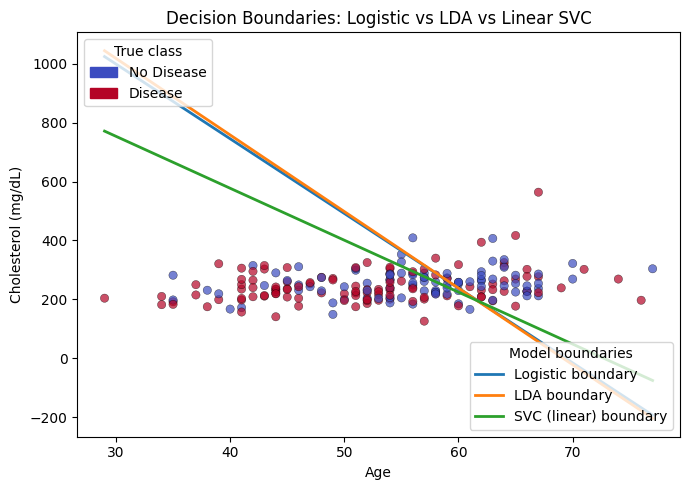

In [18]:
cnum = (df["diagnosis"] == "Disease").astype(int)

plt.figure(figsize=(7,5))
sc = plt.scatter(df["age"], df["chol"], c=cnum, cmap="coolwarm", alpha=0.7,
                 edgecolor="k", linewidth=0.3)

plt.plot(age_grid, chol_logit, label="Logistic boundary", linewidth=2)
plt.plot(age_grid, chol_lda,   label="LDA boundary",      linewidth=2)
plt.plot(age_grid, chol_svc,   label="SVC (linear) boundary", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Cholesterol (mg/dL)")
plt.title("Decision Boundaries: Logistic vs LDA vs Linear SVC")

line_legend = plt.legend(loc="lower right", title="Model boundaries")

import matplotlib.patches as mpatches
class_handles = [
    mpatches.Patch(color=plt.cm.coolwarm(0.0), label="No Disease"),
    mpatches.Patch(color=plt.cm.coolwarm(1.0), label="Disease"),
]
plt.gca().add_artist(line_legend)
plt.legend(handles=class_handles, loc="upper left", title="True class")

plt.tight_layout()
plt.show()

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!wget -q https://quarto.org/download/latest/quarto-linux-amd64.deb
!sudo dpkg -i quarto-linux-amd64.deb || true
!sudo apt-get -y -f install
!sudo dpkg -i quarto-linux-amd64.deb
!quarto check

Selecting previously unselected package quarto.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack quarto-linux-amd64.deb ...
Unpacking quarto (1.8.26) ...
Setting up quarto (1.8.26) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
(Reading database ... 124564 files and directories currently installed.)
Preparing to unpack quarto-linux-amd64.deb ...
Unpacking quarto (1.8.26) over (1.8.26) ...
Setting up quarto (1.8.26) ...
Quarto 1.8.26
[✓] Checking environment information...
      Quarto cache location: /root/.cache/quarto
[✓] Checking versions of quarto binary dependencies...
      Pandoc version 3.6.3: OK
      Dart Sass version 1.87.0: OK
      Deno version 2.3.1: OK
      Typst version 0.13.0: OK
[✓] Checking versions of quarto dependencies......OK
[✓] Checking Quarto installation......OK
      Version: 1.8.26
      Path: /op

In [24]:
!quarto render "/content/drive/My Drive/Colab Notebooks/PA 9.1.ipynb" --to html

pandoc 
  to: html
  output-file: PA 9.1.html
  standalone: true
  section-divs: true
  html-math-method: mathjax
  wrap: none
  default-image-extension: png
  variables: {}
  
metadata
  document-css: false
  link-citations: true
  date-format: long
  lang: en
  title: The Data
  
Output created: PA 9.1.html

